---
title: "Classification of word-sense definitions"
author: "Philippos Triantafyllou"
date-modified: today
---

Lab must be handed in the 5th of January.

The task is to classify word-sense definitions into coarse semantic categories named "hypersenses". We will explore several ways to use LLMs to achieve this task.

The dataset that will be used is adapted from Barque et al., 2020. These word senses were labeled with a "supersense", each supersense corresponding to a broader "hypersense".

In [ ]:

import pandas as pd
import gzip
import os

def download_and_load_tsv_gz(url):
  """Downloads a gzipped TSV file and loads it into a pandas DataFrame.
  Args:
    url: The URL of the gzipped TSV file.

  Returns:
    A pandas DataFrame containing the data from the file.
  """
  filename = url.split('/')[-1]
  if not os.path.exists(filename):
    !wget "$url"
  else:
    print(f"File '{filename}' already exists. Skipping download.")

  with gzip.open(filename, 'rt', encoding='utf-8') as f:
    df = pd.read_csv(f, sep='\t')

  return df


url = 'http://www.linguist.univ-paris-diderot.fr/~mcandito/divers/super_wiktionary_labeled_data_simplified.noex.25labels.tsv.gz'

try:
  df = download_and_load_tsv_gz(url)
  print("DataFrame loaded successfully.")
  print(df.head())  # Display the first few rows
except Exception as e:
  print(f"Error loading DataFrame: {e}")

File 'super_wiktionary_labeled_data_simplified.noex.25labels.tsv.gz' already exists. Skipping download.
DataFrame loaded successfully.
                    sense_id              entry_id         lemma  \
0      ws_1_esquerme__nom__1      esquerme__nom__1      esquerme   
1    ws_1_béruguette__nom__1    béruguette__nom__1    béruguette   
2  ws_2_agroécologie__nom__1  agroécologie__nom__1  agroécologie   
3     ws_1_webcaméra__nom__1     webcaméra__nom__1     webcaméra   
4     ws_1_Reguinois__nom__1     Reguinois__nom__1     Reguinois   

   nb_occ_lemma_frsemcor supersense        set  \
0                      0      plant  rand-test   
1                      0       food   rand-dev   
2                      0        act  rand-test   
3                      0   artifact  rand-test   
4                      0     person   rand-dev   

                                          definition  
0                                   Plante potagère.  
1            Variété d’olive allongée à pulpe

### Distribution of supersenses

<Axes: xlabel='supersense'>

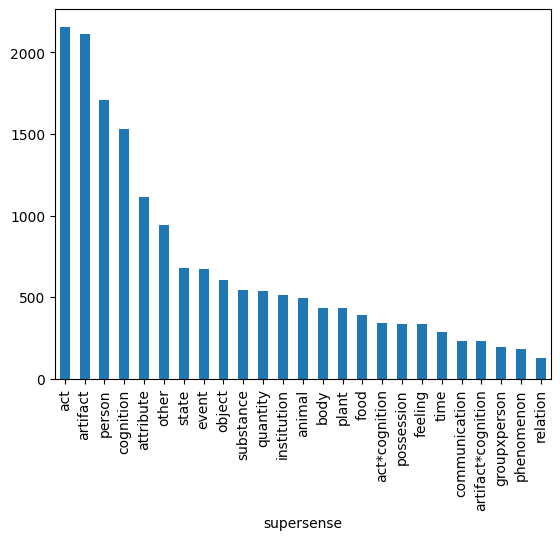

In [ ]:
df['supersense'].value_counts().plot(kind='bar')

### Distribution of hypersenses

In [ ]:
supersenses = df['supersense'].unique()
super2hyper = {'artifact': 'inanimate',
               'body': 'inanimate',
               'food': 'inanimate',
               'object': 'inanimate',
               'plant': 'inanimate',
               'substance': 'inanimate',
               'act':  'dynamic_situation',
               'event': 'dynamic_situation',
               'phenomenon': 'dynamic_situation',
               'animal': 'animate',
               'person': 'animate',
               'groupxperson': 'animate',
               'cognition': 'information',
               'communication': 'information',
               'quantity': 'quantity',
               'attribute': 'stative_situation',
               'feeling': 'stative_situation',
               'relation': 'stative_situation',
               'state': 'stative_situation',
               'time': 'time',
               'possession': 'possession',
               'institution': 'institution',
               'act*cognition': 'dynamic_situation*information',
               'artifact*cognition': 'inanimate*information',
               'other': 'other',
               }


<Axes: xlabel='hypersense'>

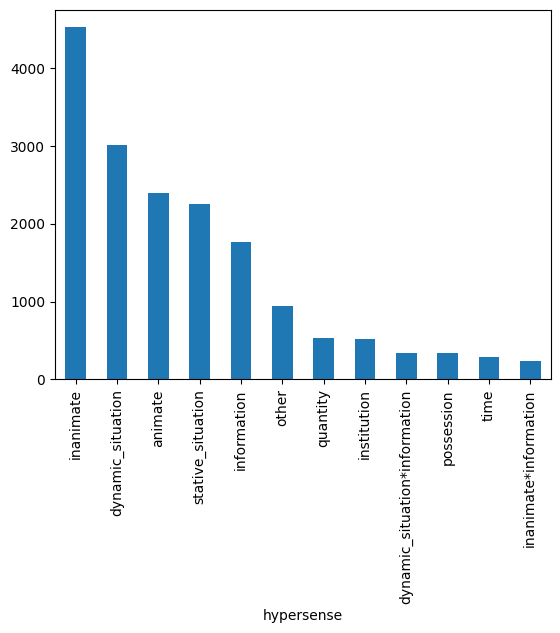

In [ ]:
df['hypersense'] = df['supersense'].map(super2hyper)
df['hypersense'].value_counts().plot(kind='bar')

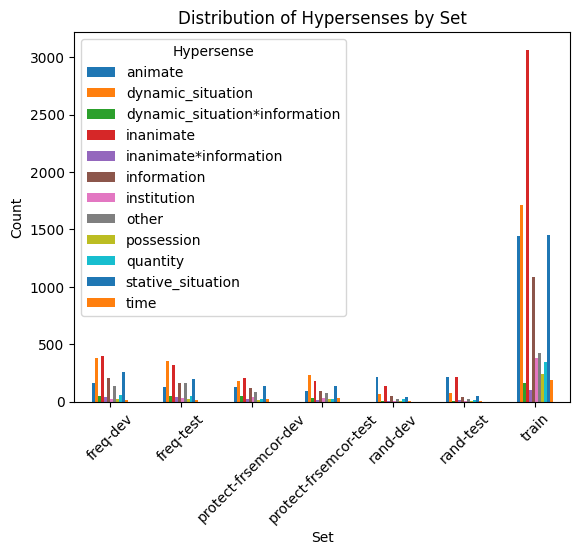

In [ ]:
# PB: note the distribution in the training set, dev and test sets are quite different

df.groupby('set')['hypersense'].value_counts().unstack().plot(kind='bar')
plt.title('Distribution of Hypersenses by Set')
plt.xlabel('Set')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Hypersense')
plt.show()

## Classifiers


You will compare
1. using a causal model with in-context learning (e.g. with N=4,8,16 examples)
  - you will use a small LLM (maximum 7B), fine-tuned for instructions
    - either use a mini model (< 2G) on google colab
    - or a quantized version of a little larger model (< 7B)
      - e.g. the bitsandbytes module on huggingface can help you : https://huggingface.co/docs/transformers/main/quantization/bitsandbytes
      - there are also some pre-quantized models e.g. by unsloth.ai (faster to download, and you save the time to quantize) : e.g. https://huggingface.co/unsloth/mistral-7b-bnb-4bit
    - https://llm-explorer.com/static/llm-leaderboards/
    - explain how you chose the model
    - a possible leaderboard for evaluation in languages other than English:
      - https://huggingface.co/spaces/Eurolingua/european-llm-leaderboard
  - or use the huggingface API to run the model on HF's servers
    - cf. https://huggingface.co/docs/huggingface_hub/guides/inference
    - (I don't know the exact amount of inference you can do with the free version)
  - Look for prompts tested in the literature to perform text classification, and adapt it to the task
    - e.g. is it better to write a prompt in English, and leave the labels in English? Or do everything in French?

2. Parameter-efficient fine-tuning on the full training set
  - see the numerous examples on the web for using LoRA or QLoRA in a google colab

3. Optional: full fine-tuning of an encoder-only French model
   - e.g. FlauBERT or CamemBERT (these are small models compared to current generative models)
   - add a classification head on top of the pre-trained encoder model, and do a full training on our data



## Methodology

The dataset comprises a training set (cf. column "set" of the dataframe), and several dev and test sets.

In all your work **you will ignore the "protect-frsemcor" instances**.
You will use rand-dev for tuning hyperparameters (including the form of prompts, the nb of demonstrations in ICL etc...), and report your FINAL results on freq-test and rand-test, for the two main methods (ICL and LoRA fine-tuning).

In your experiments,
- **figure out what kind of information can be useful to provide as input**, on top of the sense definition.
- perform sound comparisons of your various settings



## How your project will be evaluated

You will turn in a PDF file, with a report on your methodology, experiments, problems encountered, results etc...
- you should point to your colab within the pdf report
- or the pdf can be directly created from google colab, with your code and execution traces, in which case, write down in the colab the link to itself.

It is likely that you will use code seen on the web or generated via a LLM. Show me you perfectly master your code (no useless instructions, appropriate comments ...).

The overall performance is not what matters most, in particular because it would be a waste of compute energy to make too many experiments.

You project will be evaluated based on
- sound methodology
- clear and commented code
- well presented and discussed results
- error analysis (trying to figure out what kind of instances are badly classified and why?)

Bonus for new ideas on top of what is suggested above.